# Import 

In [12]:
import numpy as np 
import scipy as sp
import pandas as pd
import os
import time
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import pickle
import itertools
import networkx as nx
from matplotlib.colors import to_hex
from matplotlib.pyplot import cm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import re
# import plotly.express as px
import matplotlib.colors as mcolors
# import networkx as nx
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, to_tree

from fvec import bipartite_cooarray

In [ ]:
from module.dendorgram_utils import dendrogram_clustering
from module.data_prep import prep_grn_data, prep_go_meta, prep_tf_fam_dict, prep_foodweb_data, prep_recipe_data
from module.bipartite_vectorisation import agg_list, get_bpt_dict, all_ud_bpt_vectors, bpt_list, row_count_subset
from module.enrichment_utils import get_clustersize_range, one_test
from module.utils import insert_line_break

In [3]:
save_things = False

# Load data:

In [ ]:
# Arabidopsis gene regulatory network and associated metadata
g_reg_edges, GO_bipartite_df = prep_grn_data()
go_meta_df = prep_go_meta()

GO_meta = pd.DataFrame({'node':GO_bipartite_df['GO'], 'type':GO_bipartite_df['GO']}) # dummy dataframe
tf_family_dict = prep_tf_fam_dict()

/Users/ssm47/Desktop/thesis_code/01_vectorisation/src/module/data_prep.py:5: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../../data/grn/AtRegNet.csv', index_col=0)


In [ ]:
# tfs_labels= pd.read_csv('../data/grn/tf_family.csv')
# tfs_labels['TF Locus ID'] = tfs_labels['TF Locus ID'].str.upper()
# tf_family_dict= tfs_labels.set_index('TF Locus ID')['TF Family Name'].to_dict()

# def prep_tf_fam_dict():
#     file = open('../../data/grn/tf_family.csv')
#     data = file.readlines()
#     colnames = data[0].split(',')[:2]
#     family_data = [i.split(',')[:2] for i in data[1:]]

#     tfs_label_df = pd.DataFrame(family_data, columns=colnames)
#     tfs_label_df['TF Locus ID'] = tfs_label_df['TF Locus ID'].str.upper()
#     tf_family_dict= tfs_label_df.set_index('TF Locus ID')['TF Family Name'].to_dict()
#     return tf_family_dict



# Clustering:

## GRN vectors:

In [6]:
v = GO_bipartite_df.GO.value_counts()
single_GOs = v[v <=1].index.tolist() # GO terms that only appear once
multi_GOs = v[v >1].index.tolist() # GO terms that appear more than once


In [7]:
grn_datadir = '../../data/grn'
grn_processed_dir = grn_datadir + '/processed'
if not os.path.isdir(grn_processed_dir):
    os.makedirs(grn_processed_dir)

In [8]:
tfs = g_reg_edges.pre.unique() # all transcription factors
regulated_genes = g_reg_edges.post.unique() # all genes that are regulated
g_reg_ids = list(set(regulated_genes) | set(tfs)) # all nodes in the regulatory network
gene_ids = list(set(GO_bipartite_df.gene)) # genes that have GO labelling


In [ ]:
# # aggregate all GO terms for each gene and save it
pre_post= ['gene', 'GO', 'gene', 'GO']
fpath_prefix = grn_processed_dir + '/go_list_dict'
# go_dict = get_bpt_dict(ids=gene_ids, bpt_df=GO_bipartite_df,pre_post=pre_post, fpath_prefix=fpath_prefix)

# 4 min 34

In [13]:
go_cooarray, row_names, col_names  = bipartite_cooarray(df=GO_bipartite_df, \
                                                        row_col=['gene', 'GO'], \
                                                        weight=False, \
                                                        row_order=None, \
                                                        col_order=None)

In [17]:
fast_go_dict = {}
for i in range(go_cooarray.shape[0]):
    ith_bool = go_cooarray.row == i
    ith_goterms = col_names[go_cooarray.col[ith_bool]]
    fast_go_dict[row_names[i]] = list(ith_goterms)
    # ith_goterm_freqs = go_cooarray.data[ith_bool] # all frequencies are 1s here. 

In [18]:
tf_bool = pd.Series(row_names).isin(tfs).values

In [19]:
multi_GO_bool = pd.Series(col_names).isin(multi_GOs).values

In [20]:
tfs_go_array = go_cooarray.tocsr()[tf_bool]

tfs_go_array_summed = tfs_go_array.sum(axis=0)

In [21]:
tfs_go_array

<575x7107 sparse array of type '<class 'numpy.float64'>'
	with 4854 stored elements in Compressed Sparse Row format>

In [ ]:
# ids = tfs[:10]
# slice_ids_bool = pd.Series(row_names).isin(ids).values # bool of which rows correspond to the ids of interest
# ids_go_array = go_cooarray.tocsr()[slice_ids_bool] # cooarray of the data corresponding to ids of interest
# # tfs_go_array = go_cooarray.tocsr()[tf_bool]
# slice_ids_bool_summed = ids_go_array.sum(axis=0) # column frequencies: summed over the ids
# sliced_go_counts = slice_ids_bool_summed[multi_GO_bool] # frequency for each GO term that are in non-single GO term list
# sliced_col_names = col_names[multi_GO_bool] # column names present that are non-single GO terms
# # construct the dictionary of GO terms and the count within ids, only keep GO term entries with at least one gene associated to it. 
# ids_GO_counter = dict(zip(sliced_col_names[sliced_go_counts>0], sliced_go_counts[sliced_go_counts>0])) 


# def row_count_subset(csrarray, r_ids, c_ids, row_names, col_names):
#     '''
#     row_names and col_names specify the csrarray row and column identity. 

#     This function slices the csrarray by its row id names ``r_ids`` and column id names, ``c_ids``, 
#     and sums over the r_ids to return a dict of c_ids and their frequencies (only those that have a non-zero count).
    
#     '''

#     cids_bool = pd.Series(col_names).isin(c_ids).values # bool of which columns correspond to c_ids of interest
#     rids_bool = pd.Series(row_names).isin(r_ids).values # bool of which rows correspond to the r_ids of interest
#     rids_go_array = csrarray[rids_bool] # csrarray of the data corresponding to r_ids of interest (row slicing)
#     rids_bool_summed = rids_go_array.sum(axis=0) # column frequencies: summed over the r_ids
#     sliced_go_counts = rids_bool_summed[cids_bool] # frequency for each column id that are in c_ids list 
#     sliced_col_names = col_names[cids_bool] # column names present that are non-single GO terms

#     # construct the dictionary of c_ids and the count within r_ids, only keep c_ids with at least one r_ids associated to it. 
#     ids_counter = dict(zip(sliced_col_names[sliced_go_counts>0], sliced_go_counts[sliced_go_counts>0])) 
#     return ids_counter

In [23]:
tfs_go_counter = row_count_subset(csrarray=go_cooarray.tocsr(), r_ids=tfs, c_ids=multi_GOs, row_names=row_names, col_names=col_names)

In [24]:
len(tfs_go_counter)

619

In [25]:
sliced_go_counts = tfs_go_array_summed[multi_GO_bool]
sliced_col_names = col_names[multi_GO_bool]



In [26]:
fast_all_tfs_GO_counter = dict(zip(sliced_col_names[sliced_go_counts>0], sliced_go_counts[sliced_go_counts>0]))

In [128]:
# for k in all_tfs_GO_counter.keys():
#     val = int(all_tfs_GO_counter.get(k) - fast_all_tfs_GO_counter.get(k))
#     if val!=0:
#         print(k)

In [129]:
# v = GO_bipartite_df.GO.value_counts()
# single_GOs = v[v <=1].index.tolist() # GO terms that only appear once
# multi_GOs = v[v >1].index.tolist() # GO terms that appear more than once


# # only consider GO terms that appear more than once:
# prefix = grn_processed_dir + '/grn_GO_vectors_mutligos' # all the gene ids in the regulatory network, in/out GO vectors, ignore single GO terms.
# grn_go_vectors = all_ud_bpt_vectors(ids=g_reg_ids, edges=g_reg_edges, bpt_dict=go_dict, keep=multi_GOs, prefix=prefix)
# grn_go_vectors = all_ud_bpt_vectors(ids=g_reg_ids, edges=g_reg_edges, bpt_dict=None, keep=None, prefix=prefix)

In [11]:
grn_go_vectors = pd.read_parquet('../../data/grn/processed/grn_GO_vector_multigos.parquet')

### enrichment: 

In [28]:
ud_vect_df = grn_go_vectors.loc[list(set(GO_bipartite_df.gene.tolist()) & set(tfs))]

In [29]:
metric='euclidean'
method='ward'

ind_to_id = ud_vect_df.index.values

Z = linkage(ud_vect_df.fillna(0.), metric=metric, method=method) ####### linkage


In [45]:
rel_df = get_clustersize_range(Z=Z, ind_to_id=ind_to_id, sizes=[2, np.inf])
rel_df['n'] = rel_df.cluster.apply(len)

cluster_list = rel_df.cluster.tolist()

all_tfs_GO_counter = agg_list(list_dict=fast_go_dict, ids=tfs, ignore=single_GOs)


In [46]:
ids_go_count = agg_list(list_dict=fast_go_dict, ids=tfs[:10], ignore=single_GOs)

In [47]:
# multiple hypothesis testing - Benjamini-Hochberg procedure

alpha = 0.1

pvals_dfs=[]
enriched_go_terms = []
for cluster in cluster_list[:]:
    bpt_lists = [bpt_list(Id=i, df=GO_bipartite_df, pre_post=['gene', 'GO', '_', 'GO']) for i in cluster]
    ids_go_count = agg_list(list_dict=fast_go_dict, ids=cluster, ignore=single_GOs)
    threshold_ids_go_count = Counter({k: c for k, c in ids_go_count.items() if c >= 2})
    for_search = list(threshold_ids_go_count) # which GO terms are present? 


    n = len(cluster)
    if len(for_search)==0: # if no GO terms are present, skip the cluster
        print('No relevant GO terms present in cluster')
        print(cluster)
        pvals_dfs.append(False)
        enriched_go_terms.append([])
        continue 

    N = len(tfs)
    m = len(for_search)
    pvals = []
    ks = []
    Ks=[]
    for go_term in for_search:
        k = sum([go_term in i for i in bpt_lists]) # how many of the genes in the cluster are associated to the GO terms of interest?
        K = all_tfs_GO_counter.get(go_term)
        ks.append(k)
        Ks.append(K)
        go_term_p_val = one_test(k=k, n=n, K=K, N=N)
        pvals.append(go_term_p_val)

    
    pvals_df = pd.DataFrame({'GO_term':for_search, 'k':ks, 'K': Ks, 'p_vals':pvals}).sort_values('p_vals', ascending=True).reset_index(drop=True)
    pvals_df['n'] = n


    pvals_df['BH_adjusted'] = ((pvals_df.index + 1) * alpha)/m 
    pvals_df['Reject H_0'] = pvals_df['p_vals']<= pvals_df['BH_adjusted'] 
    max_ind = max([ind if val == True else -1 for ind, val in pvals_df['Reject H_0'].to_dict().items()])
    pvals_df.loc[:max_ind, 'Reject H_0'] = True

    pvals_dfs.append(pvals_df)
    enriched_go_terms.append(pvals_df[pvals_df['Reject H_0']==True].GO_term.values)
    
enriched_go_lens = [len(i[i['Reject H_0']==True]) if type(i) !=  bool else 0 for i in pvals_dfs]
rel_df['e_num'] = enriched_go_lens
rel_df['GO_terms'] = enriched_go_terms
# ~2 mins

# sort by number of enriched terms (most first) and if they have the same, then larger cluster should be prioritised.
cluster_df = rel_df.sort_values(['e_num', 'n'], ascending=[False, False]).reset_index(drop=False)

total = set()
save = []
for i in range(len(cluster_df)):
    clstr = cluster_df.iloc[i].cluster
    if len(total & set(clstr)) == 0:
        save.append(i)
        total |= set(clstr)

print(len(save), ': number of clusters saved')

cluster_df = cluster_df.iloc[save]

No relevant GO terms present in cluster
('AT5G17600', 'AT3G10760')
No relevant GO terms present in cluster
('AT5G09460', 'AT1G72220')
No relevant GO terms present in cluster
('AT5G23930', 'AT5G18450')
No relevant GO terms present in cluster
('AT3G10030', 'AT5G11510')
56 : number of clusters saved


In [48]:
if save_things:
    cluster_df.to_parquet(grn_processed_dir + '/grn_GO_enrichment.parquet')

### plot

In [50]:
cluster_df_todict = cluster_df[cluster_df['e_num']>0].set_index('index').to_dict('index')
index_keys = cluster_df_todict.keys()
enriched_clusters = [cluster_df_todict.get(key).get('cluster') for key in index_keys]

sorted_enriched_clusters = sorted(enriched_clusters, key=lambda x:-len(x))[:]
enriched_cluster_dict = dict(zip(range(len(enriched_clusters)), enriched_clusters))
colors = cm.rainbow(np.linspace(0,1,len(enriched_clusters)))
cluster_cmap = dict(zip(enriched_cluster_dict.keys(), colors))
cluster_cmap.update({-1 : 'white'})

node_to_clusterid_dict = {} # create a dictionary of node to cluster id 
for id, c in enriched_cluster_dict.items():
    for tf in c:
        node_to_clusterid_dict[tf] = id

tf_ids = ud_vect_df.index.values # ordered transcription factor names (all) 
node_to_clusterid_arr = np.array([node_to_clusterid_dict.get(tf, -1) for tf in tf_ids]) # if not in enriched cluster, label as -1. 

cluster_cmap = plt.matplotlib.colors.ListedColormap( np.vstack([[1,1,1,1], colors]))

In [51]:
print('Enriched cluster coverage: ', cluster_df.n.sum()/len(tfs))

Enriched cluster coverage:  0.9637931034482758


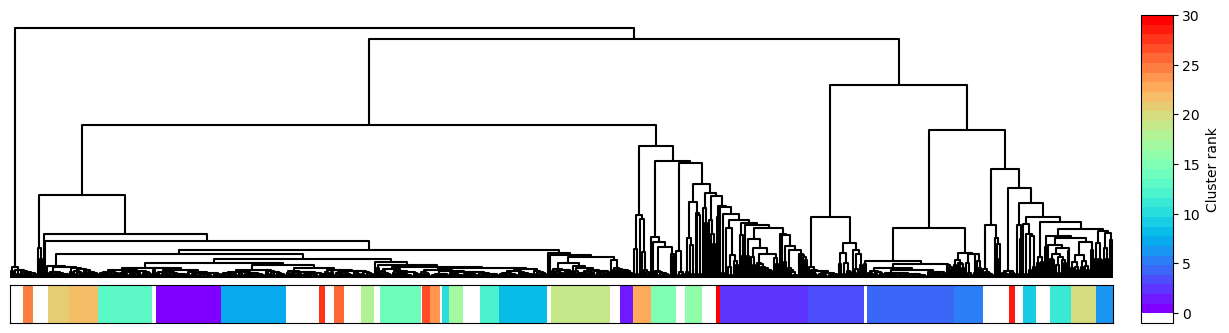

In [52]:
fig = plt.figure(figsize=(15, 4))
# fig.suptitle(f'{M} neighbours', fontsize=16)

gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)
gs1 = GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[7,1],
                                                  hspace=0.05)
legend_ax = fig.add_subplot(gs0[1])


ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black')
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()


ax = fig.add_subplot(gs1[1], sharex=ax_col_dendrogram)
colrow = ax.imshow(node_to_clusterid_arr[xind].reshape((1,-1)), aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
ax.set_yticks([])
# ax.set_ylabel('cluster id', rotation=0, ha='right', va='center')
ax.set_xticks([])
plt.setp(ax.get_xticklabels(), visible=False)
fig.colorbar(colrow, cax=legend_ax, label='Cluster rank')
if save_things:
    plt.savefig('../figures/grn/f1a_dendrogram.pdf', dpi=300)
plt.show()

In [53]:
label_dict=tf_family_dict
go_meta_dict = go_meta_df.set_index('GO_term')['GO_meta'].to_dict()

In [54]:
maxenriched_cluster = list(enriched_clusters[0])
Z_maxenriched = linkage(ud_vect_df.fillna(0.).loc[maxenriched_cluster], metric=metric, method=method) ####### linkage
# maxenriched_labels = [i + " : " + str(label_dict.get(i)) for i in maxenriched_cluster]
maxenriched_labels = [i + " (" + str(label_dict.get(i)) + ")" for i in maxenriched_cluster]

# maxenriched_labels = [str(label_dict.get(i)) for i in maxenriched_cluster]

maxsized_cluster = list(sorted_enriched_clusters[0])
Z_maxsized = linkage(ud_vect_df.fillna(0.).loc[maxsized_cluster], metric=metric, method=method) ####### linkage
# maxsized_labels = [i + " : " + str(label_dict.get(i)) for i in maxsized_cluster]
maxsized_labels = [i + " (" +str(label_dict.get(i)) + ")"  for i in maxsized_cluster]

# maxsized_labels = [str(label_dict.get(i)) for i in maxsized_cluster]

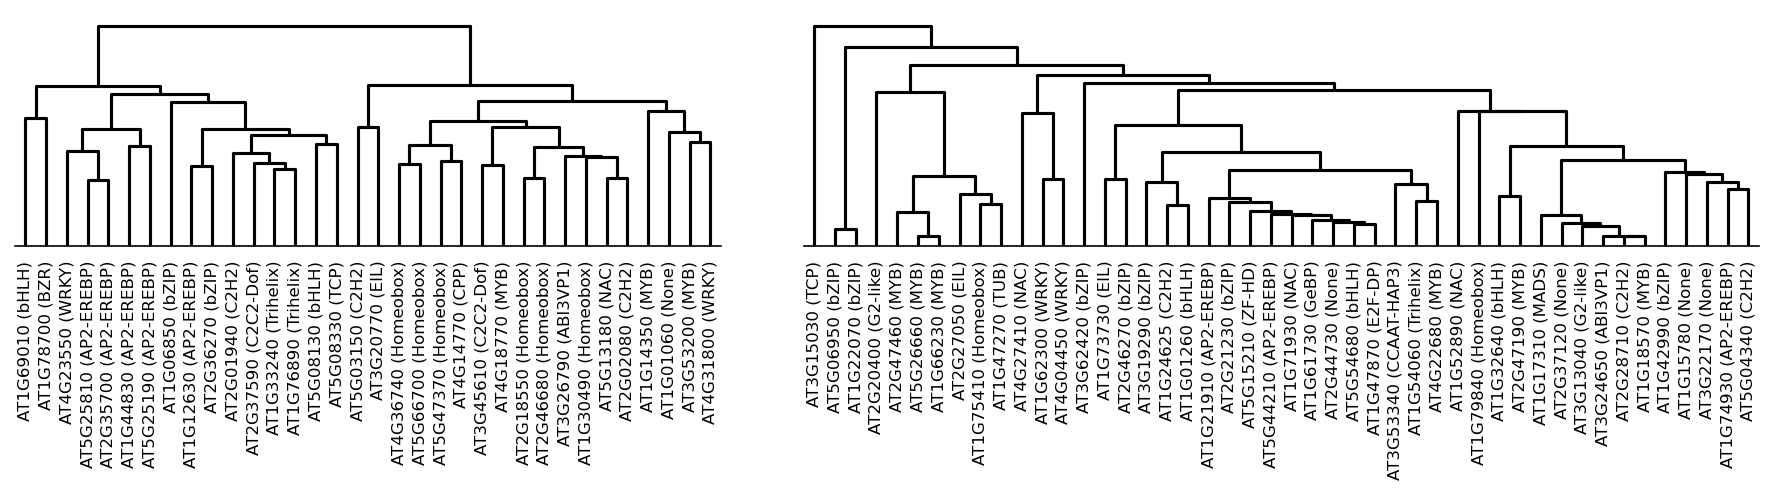

In [55]:
fig = plt.figure(figsize=(15, 2), dpi=150)
# fig.suptitle(f'{M} neighbours', fontsize=16)

gs0 = GridSpec(1,2, figure=fig, wspace=0.1, width_ratios=[len(enriched_clusters[0]), len(sorted_enriched_clusters[0])])


dax_1= fig.add_subplot(gs0[1])
dax_2= fig.add_subplot(gs0[0])

Z_maxenriched_dendrogram = sp.cluster.hierarchy.dendrogram(Z_maxenriched,labels=maxenriched_labels, ax=dax_2, color_threshold=0, above_threshold_color='black',leaf_font_size=8)
Z_maxsized_dendrogram = sp.cluster.hierarchy.dendrogram(Z_maxsized,labels=maxsized_labels, ax=dax_1, color_threshold=0, above_threshold_color='black',leaf_font_size=8)

dax_1.set_xticks(dax_1.get_xticks(), dax_1.get_xticklabels(), rotation=90, va='center', ha='right', rotation_mode='anchor')# dax_1.set_axis_off()
dax_2.set_xticks(dax_2.get_xticks(), dax_2.get_xticklabels(), rotation=90, ha='right', va='center', rotation_mode='anchor')# dax_1.set_axis_off()
dax_1.set_yticks([])
dax_2.set_yticks([])

# dax_2.set_axis_off()
dax_1.spines[['right', 'top', 'left']].set_visible(False)
dax_2.spines[['right', 'top', 'left']].set_visible(False)
# plt.tight_layout()
# save_things = False
if save_things:
    plt.savefig('../figures/grn/f1bc_dendrogram.pdf', dpi=300)

plt.show()

In [ ]:
# def insert_line_break(s):
#     if len(s) > 50:
#         # Find the last space before or at the 55th character
#         break_pos = s.rfind(' ', 0, 50)
#         if break_pos == -1:
#             # No space found before 55 — fall back to hard break
#             break_pos = 50
#         return s[:break_pos] + '\n' + s[break_pos+1:]
#     return s

# # Example
# example = "This is a long string that definitely goes well beyond fifty-five characters in total length."
# print(insert_line_break(example))

In [58]:
largest_cluster_data = [(i, insert_line_break(go_meta_dict.get(i))) for i in cluster_df.sort_values('n', ascending=False).GO_terms.iloc[0]]

In [59]:
most_enriched_cluster_data = [(i, insert_line_break(go_meta_dict.get(i))) for i in cluster_df.sort_values('e_num', ascending=False).GO_terms.iloc[0]]

In [ ]:


# def make_GO_table(data, ax, highlight_row=None):

#     # fig, ax = plt.subplots(figsize=(8, 3))
#     ax.axis('off')

#     # Create the table
#     table = ax.table(
#         cellText=data,
#         colLabels=['GO terms', 'Description'],
#         cellLoc='center',
#         loc='center'
#     )

#     table.auto_set_font_size(False)
#     table.set_fontsize(12)
#     table.scale(1, 1.8)

#     col_widths = [0.2,0.8]  # fractions of figure width
#     # nrows, ncols = df.shape

#     for i in range(len(data)+1):
#         for j in range(2):
#             cell = table[i, j]

#             cell.set_width(col_widths[j])
#             cell.set_edgecolor('black')


#     GO_col = 0  # "Dist"
#     desc_col = 1

#     for row in range(len(data)+1):
#         GO_col_cell = table[(row, GO_col)]  # +1 to skip header row
#         text = GO_col_cell.get_text()
#         text.set_fontweight('bold')
#         GO_col_cell = table[(row, desc_col)]  # +1 to skip header row
#         GO_col_cell.get_text().set_ha('left')
#         desc_col_cell = table[(row, desc_col)]
#         text = desc_col_cell.get_text().get_text()
#         if '\n' in text:
#             highlight_row = row

#     if highlight_row is not None:
#         # print(highlight_row)
#         for col in range(2):  # Number of columns
#             table[(highlight_row, col)].set_height(0.1) 

#     # Optional: bold the column header too
#     n_cols = 2
#     for col in range(n_cols):
#         header_cell = table[(0, col)]
#         header_cell.get_text().set_fontweight('bold')    # plt.show()
#         header_cell.get_text().set_fontsize(15)
#     # return fig

In [152]:
# fig = make_GO_table(data=most_enriched_cluster_data)

In [153]:
# fig = make_GO_table(data=largest_cluster_data)

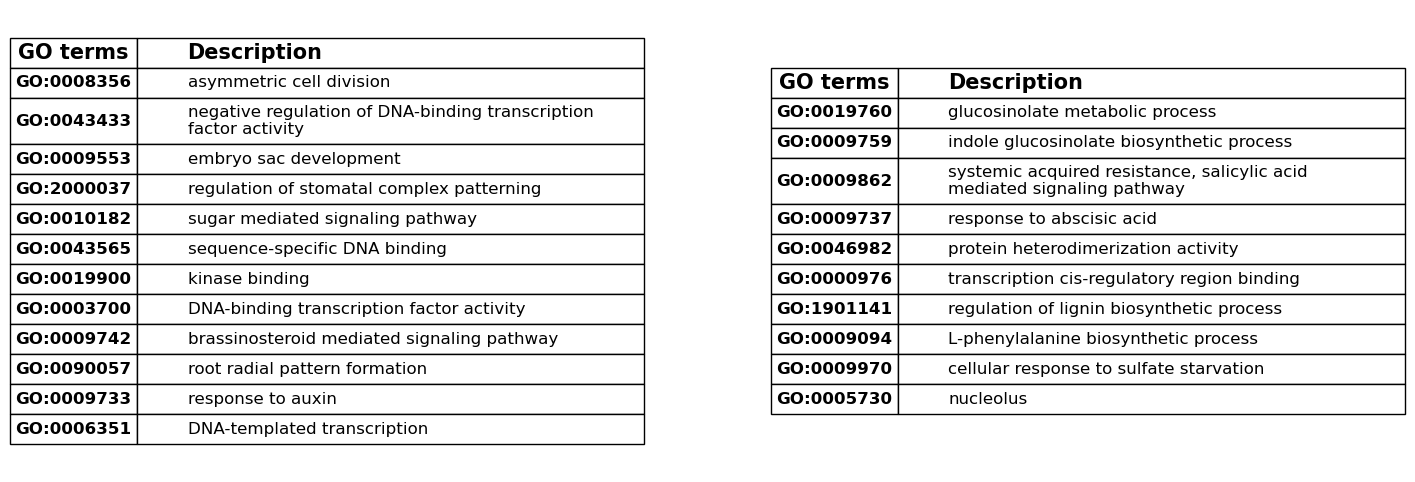

In [ ]:
fig = plt.figure(figsize=(18, 6))
gs = GridSpec(1, 2, width_ratios=[1, 1], wspace=0.2)  # Equal space
# First table in top cell
ax1 = fig.add_subplot(gs[0])
ax1.axis('off')
make_GO_table(data=most_enriched_cluster_data, ax=ax1)

# Second table in bottom cell
ax2 = fig.add_subplot(gs[1])
ax2.axis('off')
make_GO_table(data=largest_cluster_data, ax=ax2)
if save_things:
    plt.savefig('../../figures/grn/f1bc_table.png', dpi=300)
    plt.savefig('../../figures/grn/f1bc_table.pdf', dpi=300)
plt.show()


In [156]:
most_enriched_cluster_data

[('GO:0008356', 'asymmetric cell division'),
 ('GO:0043433',
  'negative regulation of DNA-binding transcription\nfactor activity'),
 ('GO:0009553', 'embryo sac development'),
 ('GO:2000037', 'regulation of stomatal complex patterning'),
 ('GO:0010182', 'sugar mediated signaling pathway'),
 ('GO:0043565', 'sequence-specific DNA binding'),
 ('GO:0019900', 'kinase binding'),
 ('GO:0003700', 'DNA-binding transcription factor activity'),
 ('GO:0090057', 'root radial pattern formation'),
 ('GO:0009742', 'brassinosteroid mediated signaling pathway'),
 ('GO:0009733', 'response to auxin'),
 ('GO:0006351', 'DNA-templated transcription')]

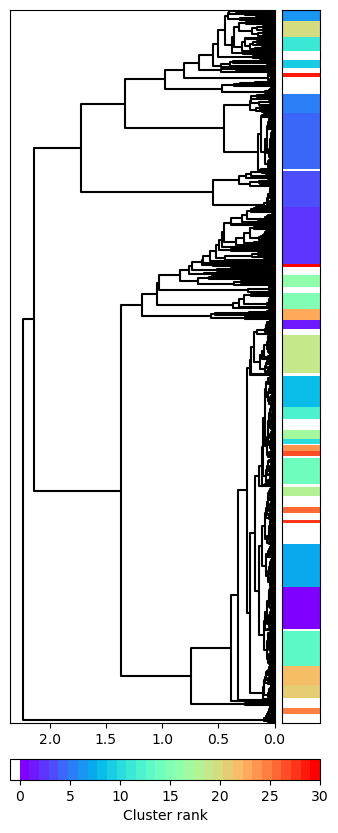

In [62]:
# fig = plt.figure(figsize=(4, 10))
# col_dendrogram = sp.cluster.hierarchy.dendrogram(Z,no_labels=True, orientation='left', color_threshold=0, above_threshold_color='black')
# if save_things:
#     plt.savefig('../figures/grn/s1_smalldendrogram.png', dpi=300)
# plt.show()



fig = plt.figure(figsize=(4, 10))
# fig.suptitle(f'{M} neighbours', fontsize=16)

gs0 = GridSpec(2,1, figure=fig,height_ratios=[35,1], wspace=0.05, hspace=0.1)
gs1 = GridSpecFromSubplotSpec(1,2, subplot_spec=gs0[0],
                                                  width_ratios=[7,1],
                                                  wspace=0.05)
legend_ax = fig.add_subplot(gs0[1])


ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = sp.cluster.hierarchy.dendrogram(Z, ax=ax_col_dendrogram,orientation='left', color_threshold=0, above_threshold_color='black', no_labels=True)
# ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()


ax = fig.add_subplot(gs1[1], ) # sharex=ax_col_dendrogram
colrow = ax.imshow(node_to_clusterid_arr[xind][::-1].reshape((1,-1)).T, aspect='auto', extent=[xmin,xmax,0,1], cmap=cluster_cmap, interpolation='nearest')
ax.set_yticks([])
# ax.set_xlabel('Cluster rank', rotation=0, ha='center', va='top')
ax.set_xticks([])
plt.setp(ax.get_xticklabels(), visible=False)
fig.colorbar(colrow, cax=legend_ax, label='Cluster rank', orientation='horizontal')
if save_things:
    plt.savefig('../../figures/grn/s1_smalldendrogram.png', dpi=300)
# plt.tight_layout()
plt.show()


/var/folders/hk/bsx9hgyx4t16l4wbtx2vwmcw0000gp/T/ipykernel_49224/2660634583.py:72: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


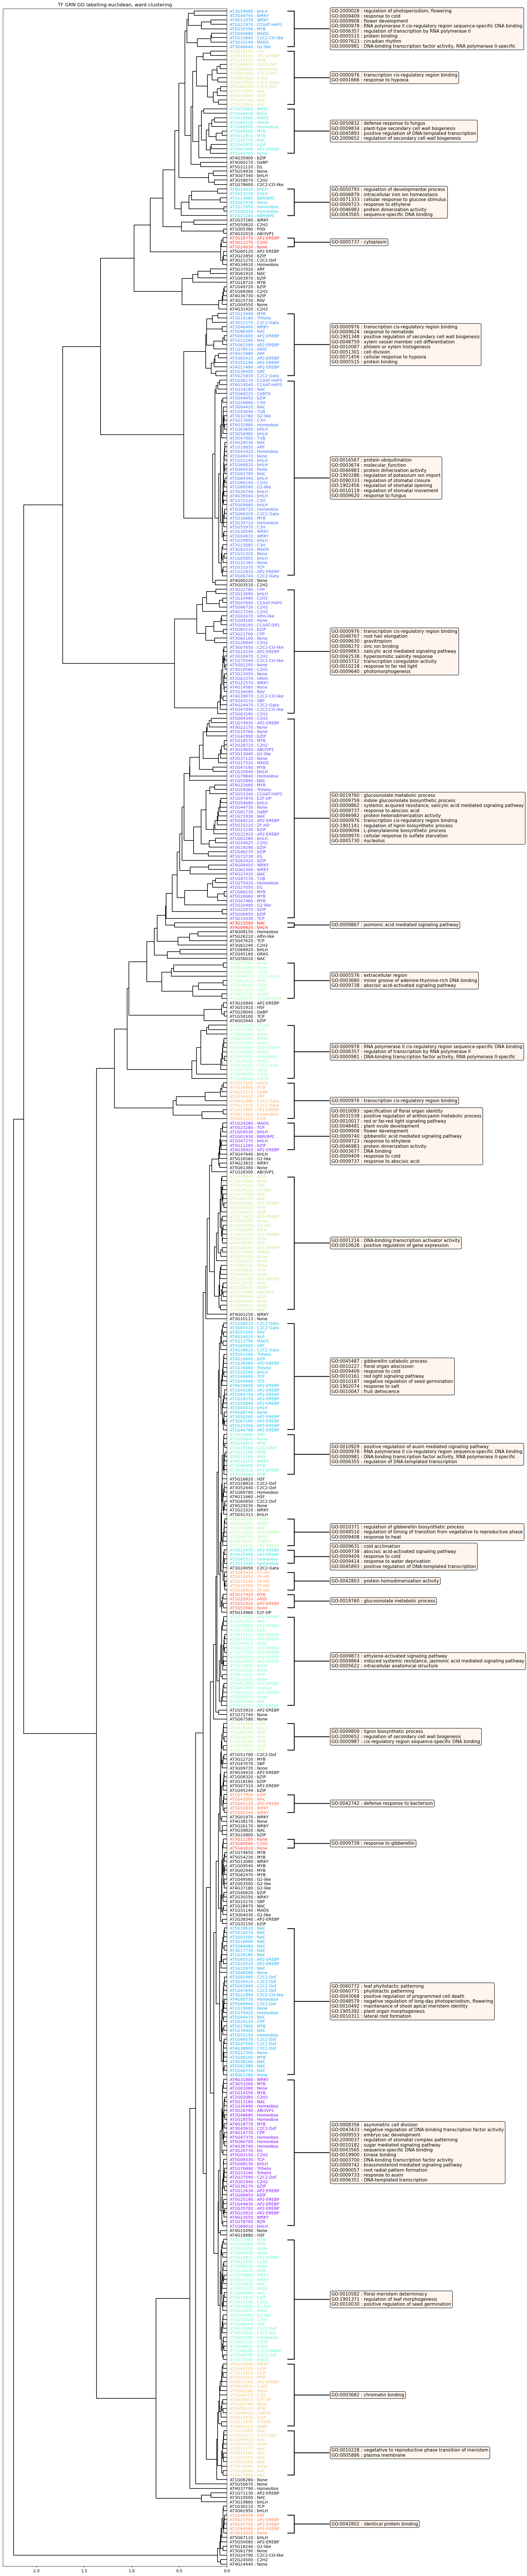

In [63]:
metric='euclidean'
method='ward'

ind_to_id = ud_vect_df.index.values

Z = linkage(ud_vect_df.fillna(0.), metric=metric, method=method) ####### linkage
label_dict=tf_family_dict
t=0
title_str=f'TF GRN GO labelling {metric}, {method} clustering'
labels=ind_to_id
clusters=enriched_clusters
size = len(labels)*80/400 
plt.figure(figsize=(10,size))
only_clusters = set(np.hstack(clusters))
if label_dict:
    clstr_labels = [i + " : " + str(label_dict.get(i)) for i in labels]

else:
    clstr_labels=labels
dendrograms = dendrogram(Z, labels=clstr_labels, get_leaves=True, orientation='left', above_threshold_color='black', color_threshold=t);


colors = cm.rainbow(np.linspace(0,1,len(clusters)))
ax = plt.gca()
bbox_args = dict(boxstyle="round", fc="#FFF5EE")

arrow_args = dict(arrowstyle="->")
ylbls = ax.get_ymajorticklabels()
for i in range(len(colors)):
    clstr = clusters[i]
    # print(clstr)
    for lbl in ylbls:
        label_colors = {'True' : colors[i], 'False' : 'black'}
        id_name = lbl.get_text().split(" : ")[0]
        is_clstr = id_name in clstr
        if is_clstr:
            lbl.set_color(label_colors[str(is_clstr)])

for key, value in cluster_df_todict.items():
    ith_cluster = value['cluster']
    e_num = value['e_num']
    n = value['n']
    go_terms = value['GO_terms']
    
    ith_indices = []
    for leaf_label in ylbls:
        node = leaf_label.get_text().split(" : ")[0]
        if node in ith_cluster:
            ith_indices.append(leaf_label.get_position()[1]) # get y position

    mn_pos, mx_pos = ith_indices[0], ith_indices[-1]

    pos_mid = (mn_pos+mx_pos)/2

    pos_range = mx_pos-mn_pos
    go_desc = [i+ ' : ' + go_meta_dict[i] for i in go_terms]
    text = '\n'.join(go_desc)
    # print(go_terms[0])
    # if len(go_desc) > 5:
    #     text = '\n'.join(go_desc[:5]) + f'\n{e_num} total' 
    ax.annotate(''.join(text),
                xy=(-0.7,pos_mid), xycoords="data",
                xytext=(-1.1,pos_mid),
                #  textcoords=OffsetFrom(ax.bbox, (0, 0), "points"),
                ha="left", va="center",
                bbox=bbox_args,fontsize=11,
                arrowprops=dict(arrowstyle=f'-[, widthB={pos_range/20}, lengthB=1.5', lw=2.0, color='k'), annotation_clip=False)


plt.yticks(fontsize=10)
plt.title(title_str)
plt.tight_layout()
if save_things:
    plt.savefig(f'../../figures/grn/s1_TF_GRN_GO_clustering_BH_all_GO_annotated.pdf', bbox_inches='tight')
plt.show()

# Food web:

In [64]:
full = False
save_things = False


In [65]:
fw_df, meta_df_filtered, meta_fine_df_filtered, meta_fine_df_2_filtered = prep_foodweb_data()

In [66]:
fw_data = {'fw': fw_df, 'meta_f': meta_df_filtered, 'meta_ff': meta_fine_df_filtered, 'meta_fff': meta_fine_df_2_filtered}

vectors = {}
for key in ['f', 'ff', 'fff']: # coarseness of food web animal labelling: more 'f's the finer...
    v = pd.read_parquet(f'../../data/foodweb/processed/{key}_vectors.parquet')
    vectors[f'{key}_vectors'] = v

In [67]:
mode = 'fff' # which level of coarseness in the food web animal labelling to use
fw_meta = fw_data[f'meta_{mode}']
fw_vectors = vectors[f'{mode}_vectors']

unique_types = fw_meta['type'].unique()
in_cols = [i + '_in' for i in unique_types]
out_cols = [i + '_out' for i in unique_types]

In [68]:
fw_label_meta = fw_data[f'meta_f'] # use the coarsest labelling for visualisation


In [69]:
metric = 'euclidean'
method = 'ward'

ind_to_id = fw_vectors.index.values
Z = linkage(fw_vectors.fillna(0).iloc[:, :-2], metric=metric, method=method) 

In [70]:
meta_dict = fw_label_meta.set_index('node').type.to_dict()
types_unique = fw_label_meta.type.unique()
ind_to_meta = [meta_dict.get(i) for i in ind_to_id]

types_to_numeric =dict(zip(types_unique, [0,0,0,0,0,1,1,1,2,2,2,2,2,3,4,5,5,5,5])) # reassign the types to a numeric value
types_unique = set(types_to_numeric.values())

ind_to_numeric_meta = [types_to_numeric.get(meta) for meta in ind_to_meta]

numeric_to_types = {}
for t, numeric in types_to_numeric.items():
    l = numeric_to_types.get(numeric, list())
    l.append(t)
    numeric_to_types[numeric] = l

numeric_to_typestr = []
for numeric, tlist in numeric_to_types.items():
    numeric_to_typestr.append(', '.join(numeric_to_types[numeric]))

numeric_meta_dict = dict(zip(fw_label_meta.node, fw_label_meta.type.apply(types_to_numeric.get)))

# colors = cm.tab10.colors[:len(types_unique)]


In [71]:
# Generate a colormap for unique types
colormap = plt.colormaps['viridis']
norm = plt.Normalize(vmin=0, vmax=len(types_unique) - 1)
colors = [colormap(norm(i)) for i in range(len(types_unique))]
type_cmap = plt.matplotlib.colors.ListedColormap(colors)


In [72]:
cutoff = 0.2
t = cutoff*max(Z[:,2])

exact_clustering_from_cols = dict()
small_clstr = set()
assigned=set()

# rawcolours = np.array(dendrograms['leaves_color_list'])
rawcolours = fcluster(Z=Z, t=t, criterion='distance') 


for i in list(set(rawcolours)): # remove the "other" unlcustered nodes
    if i != 'C000000':
        col_cl = set(np.array(ind_to_id)[np.where(rawcolours==i)])
        if len(col_cl) > 1: # don't take clusters of size 1
            exact_clustering_from_cols[i] = col_cl
            assigned |= col_cl
        else:
            small_clstr |= col_cl
exact_clustering_from_cols = {rank+1: v for rank, (_, v) in enumerate(sorted(exact_clustering_from_cols.items(), key=lambda item: len(item[1]), reverse=True))}
cluster_labels = list(exact_clustering_from_cols.keys())
cluster_lens = [len(exact_clustering_from_cols.get(i)) for i in cluster_labels]

cluster_lens_tuple = sorted(list(zip(cluster_labels, cluster_lens)), key=lambda x: -x[1])

plot_n = None

clusters_to_plot = [exact_clustering_from_cols.get(i[0]) for i in cluster_lens_tuple[:plot_n]]
cluster_labels_to_plot = [i[0] for i in cluster_lens_tuple[:plot_n]]
palette = cm.rainbow(np.linspace(0,1,len(cluster_labels_to_plot))) # sns.color_palette('husl', n_colors=plot_n).as_hex()
palette_dict = dict(zip(cluster_labels_to_plot, [to_hex(i) for i in palette]))

leaf_clabel_dict = {}
for key, val in exact_clustering_from_cols.items():
    for i in val:
        leaf_clabel_dict[i] = key


# animals_of_interest = np.hstack([list(i) for i in clusters_to_plot])

leaf_palette = {}
dflt_col = "black"   # Unclustered black

for i in ind_to_id:
    leaf_palette[i] = palette_dict.get(leaf_clabel_dict.get(i), dflt_col)

# Sorted cluster labels and their colors
cluster_labels = sorted(palette_dict.keys())
cluster_colors = [palette_dict[k] for k in cluster_labels]

# Create colormap and norm
cmap = mcolors.ListedColormap(cluster_colors)
bounds = np.array(cluster_labels + [max(cluster_labels) + 1]) - 0.5  # to center color ticks
norm = mcolors.BoundaryNorm(bounds, cmap.N)

link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
  c1, c2 = (link_cols[x] if x > len(Z) else leaf_palette[ind_to_id[x]]
    for x in i12)
  link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col


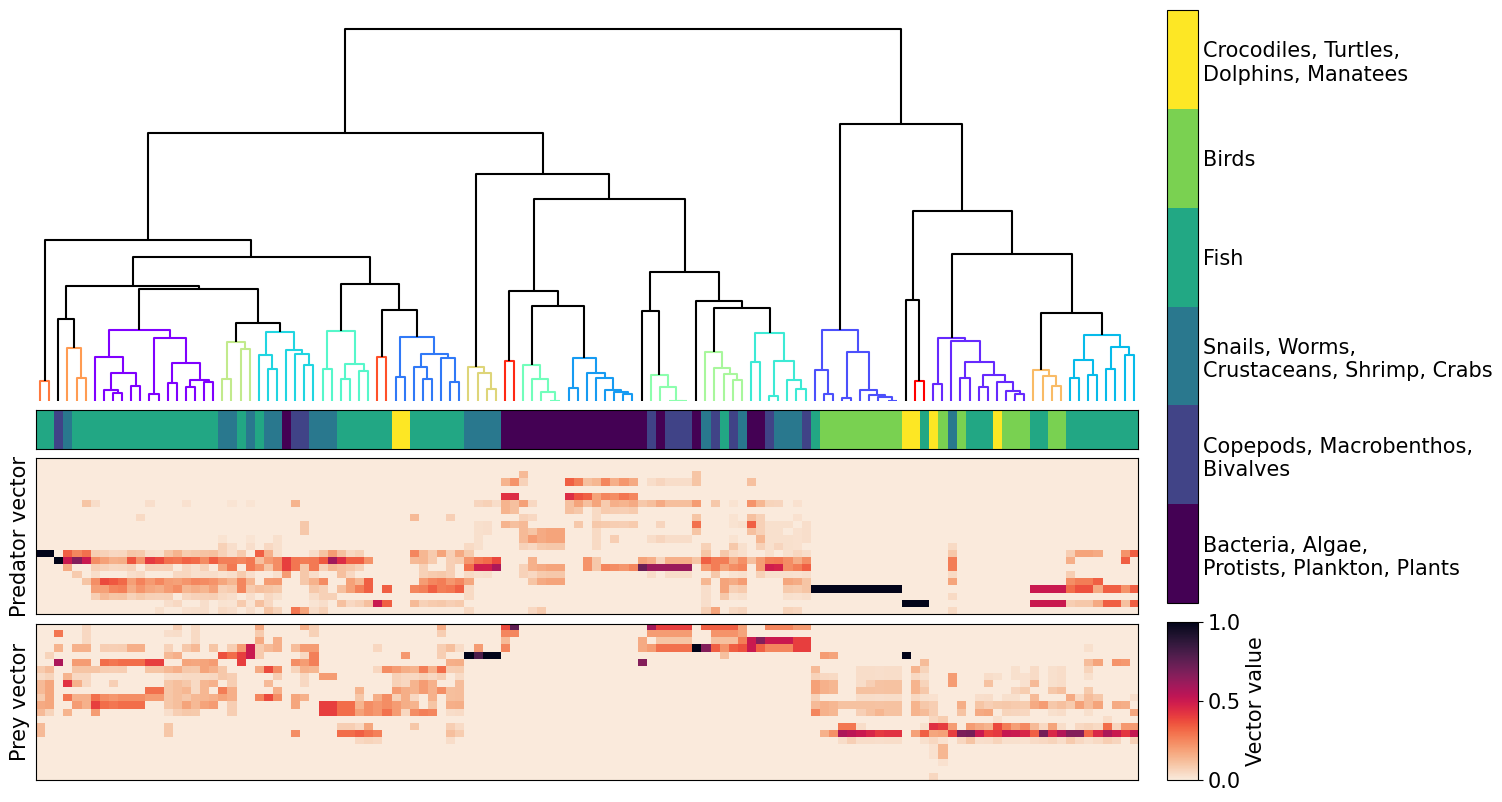

In [73]:

# full=False # for full figure with labelling
# save_things = False


fig = plt.figure(figsize=(15, 10))

# Define gridspecs for layout
gs0 = GridSpec(1, 2, figure=fig, width_ratios=[35, 1], wspace=0.05)
gs1 = GridSpecFromSubplotSpec(4, 1, subplot_spec=gs0[0], height_ratios=[10, 1, 4, 4], hspace=0.05)
# gs2 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1], height_ratios=[15, 4], hspace=0.05)
gs2 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1], height_ratios=[15, 4], hspace=0.05)

# Add subplots
legend_ax = fig.add_subplot(gs2[0])
ax_col_dendrogram = fig.add_subplot(gs1[0])

# gs3 = GridSpecFromSubplotSpec(3, 1, subplot_spec=gs2[1], height_ratios=[15, 4], hspace=0.05)

sec_legend_ax = fig.add_subplot(gs2[1])


# Plot dendrogram
col_dendrogram = dendrogram(
    Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black',
    link_color_func=lambda x: link_cols[x]
)

# col_dendrogram = dendrogram(
#     Z, ax=ax_col_dendrogram, color_threshold=t*1.5, above_threshold_color='black',
# )

ax_col_dendrogram.set_axis_off()

# Get x-axis indices and limits
xind = col_dendrogram['leaves']
xmin, xmax = ax_col_dendrogram.get_xlim()

# Plot metadata heatmap
arr = np.array([numeric_meta_dict.get(animal) for animal in ind_to_id])
ax_meta = fig.add_subplot(gs1[1], sharex=ax_col_dendrogram)
colrow = ax_meta.imshow(
    arr[xind].reshape((1, -1)), aspect='auto', extent=[xmin, xmax, 0, 1],
    cmap=type_cmap, interpolation='nearest'
)
ax_meta.set_yticks([])
ax_meta.set_xticks([])

# Add colorbar for metadata
fig.colorbar(colrow, cax=legend_ax, label='')
yticks = np.linspace(*legend_ax.get_ylim(), len(types_unique) + 1)[:-1] + (legend_ax.get_ylim()[1] / len(types_unique) / 2)
legend_ax.set_yticks(ticks=yticks)
newstrings = []
for i in numeric_to_typestr:
    splitstring = i.split(' ')
    if len(splitstring)>2:
        splitstring = splitstring[:1] + [splitstring[1] + '\n' + splitstring[2]] + splitstring[3:]
        # splitstring[2] += '\n'
    splitstring = ' '.join(splitstring)

    newstrings.append(splitstring)

legend_ax.set_yticklabels(newstrings, size=15)
legend_ax.tick_params(length=0)

# Plot predator and prey vectors
predator_vec_ax = fig.add_subplot(gs1[2])
prey_vec_ax = fig.add_subplot(gs1[3])

pv_img = predator_vec_ax.imshow(
    fw_vectors.loc[:, out_cols].iloc[xind, :-2].fillna(0).T, cmap='rocket_r',
    aspect='auto', extent=[0, 1, 0, 1], interpolation='nearest'
)
prey_vec_ax.imshow(
    fw_vectors.loc[:, in_cols].iloc[xind, :-2].fillna(0).T, cmap='rocket_r',
    aspect='auto', extent=[0, 1, 0, 1], interpolation='nearest'
)

# Style predator and prey vector axes
for ax, label in zip([predator_vec_ax, prey_vec_ax], ['Predator vector', 'Prey vector']):
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylabel(label, rotation=90, size=15)

# Add colorbar for predator vector
vcbar = plt.colorbar(pv_img, cax=sec_legend_ax)
vcbar.set_label('Vector value', size=15)  # Set label text and size
sec_legend_ax.set_yticks([0, 0.5, 1])
sec_legend_ax.tick_params(axis='y', labelsize=15)
suffix= ''
if full:
    for ax, label, col_label in zip([predator_vec_ax, prey_vec_ax], ['Predator vector', 'Prey vector'], [out_cols, in_cols]):
        ax.set_yticks(np.linspace(0, 1, len(col_label)+1)[:-1] + 1/(2*(len(col_label)+1)))
        ax.set_yticklabels(col_label, ha='right', size=6)

    prey_vec_ax.set_xticks(np.linspace(0, 1, len(ind_to_id[xind])+1)[:-1] + 1/(2*(len(ind_to_id[xind])+1)))
    prey_vec_ax.set_xticklabels(ind_to_id[xind], rotation=90, ha='center', size=7)
    suffix = '_full'
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        animal_label = lbl.get_text()
        colour = leaf_palette.get(animal_label, False)
        if colour:
            lbl.set_color(colour)
    cbar_ax = fig.add_subplot(gs2[1])

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Cluster rank', size=15)
    cbar_ax.set_yticks(cluster_labels[::4])
    # cbar.ax.set_yticklabels([str(i) for i in cluster_labels])  # or custom labels
    cbar.ax.tick_params(labelsize=12)
    cbar_ax.tick_params(which='minor', bottom=False, top=False, left=False, right=False)

    pos = cbar_ax.get_position()

    # Adjust values: (x0, y0, width, height)
    new_pos = [pos.x0 + 0.1, pos.y0, pos.width, pos.height]
    cbar_ax.set_position(new_pos)

if save_things:
    plt.savefig(f'../../figures/fw/f2a_dendrogram{suffix}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'../../figures/fw/f2a_dendrogram{suffix}.png', dpi=300, bbox_inches='tight')

plt.show()


In [74]:
# save_things = False


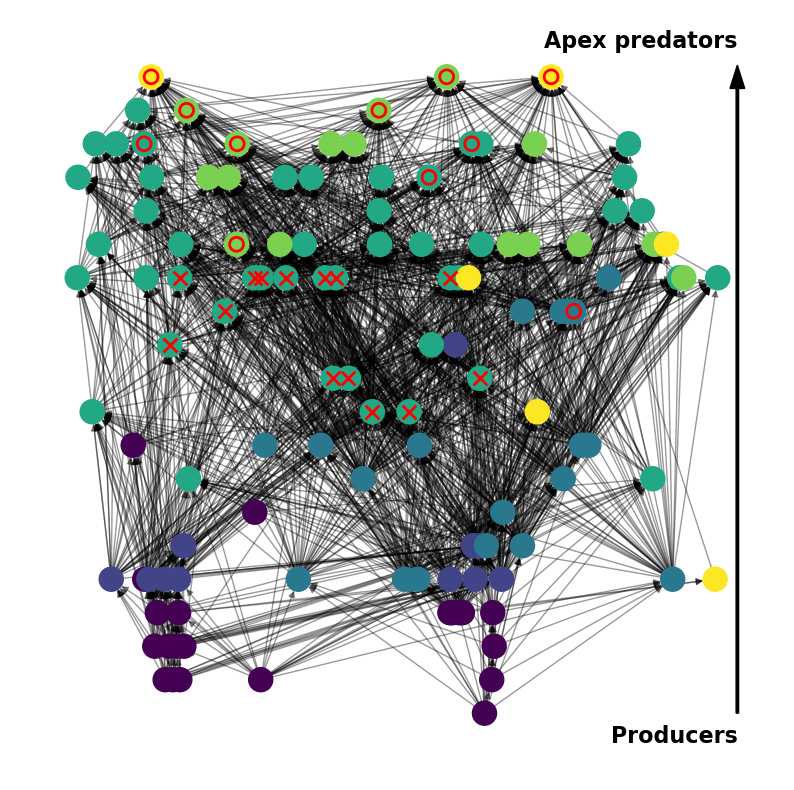

In [75]:

# Create a colormap for clusters
clustercmap = {val: type_cmap(ind) for ind, val in enumerate(list(types_unique))}
assignment = dict(zip(ind_to_id, arr))
partition = [[node for node, val in assignment.items() if val == cl] for cl in list(types_unique)]

# Create a directed graph and add edges
fw_g = nx.DiGraph()
fw_g.add_edges_from(fw_df[['prey', 'predator']].to_numpy(), alpha=0.4)

# Generate positions for nodes
pos = nx.nx_agraph.graphviz_layout(fw_g, prog='dot')  # Requires Graphviz
pos = {key: (val[0], -val[1]) for key, val in pos.items()}

# Plot the graph
plt.figure(figsize=(10, 10))
for ind, nodelist in enumerate(partition):
    nx.draw_networkx_nodes(fw_g, nodelist=nodelist, node_color=[clustercmap.get(ind) for _ in nodelist], pos=pos)

# Add labels or markers for clusters of interest
shapes = ['x', 'o']  # Define marker shapes
for cluster, label in zip(clusters_to_plot, shapes):
    fc = 'none' if label == 'o' else 'red'
    for node in cluster:
        x, y = pos[node]
        plt.scatter(x, y, marker=label, color='red', s=100, zorder=5, facecolor=fc, linewidths=2)

# Draw edges
nx.draw_networkx_edges(fw_g, pos=pos, alpha=0.4)

# Add an arrow to indicate hierarchy
max_x = max(x for x, y in pos.values())
max_y = max(y for x, y in pos.values())
min_y = min(y for x, y in pos.values())
arrow_x = max_x + 800
arrow_length = max_y - min_y + 25

plt.arrow(
    x=arrow_x, y=min_y, dx=0, dy=arrow_length,
    head_width=600, head_length=50, fc='black', ec='black',
    length_includes_head=True, width=100
)

# Add text labels for hierarchy
plt.text(arrow_x, min_y + arrow_length + 50, 'Apex predators', va='center', ha='right', fontsize=16, weight='bold')
plt.text(arrow_x, min_y - 50, 'Producers', va='center', ha='right', fontsize=16, weight='bold')

# Finalize plot
plt.axis('off')

# Save the plot if required
if save_things:
    plt.savefig('../../figures/fw/f2b_foodweb_graph.png', dpi=300, bbox_inches='tight')
    plt.savefig('../../figures/fw/f2b_foodweb_graph.pdf', dpi=300, bbox_inches='tight')

plt.show()


# Recipe network:

In [76]:
rn_df, meta_df = prep_recipe_data()
cuisine_list = meta_df.cuisine.dropna().unique()
recipe_list = rn_df.r_id.dropna().unique()

ingredient_list = list(set(rn_df.ingredient.dropna().unique()) - {''})
rn_df = rn_df[rn_df['ingredient'].isin(ingredient_list)].reset_index(drop=True)

In [77]:
cs_i_vectors = pd.read_parquet('../../data/recipe/processed/cs_i_vectors.parquet')

is_c_vectors = pd.read_parquet('../../data/recipe/processed/is_c_vectors.parquet')

In [78]:
metric = 'euclidean'
method = 'ward'
ind_to_id = np.array(ingredient_list)
# ind_to_id = cs_i_vectors.columns.values

Z = linkage(cs_i_vectors.loc[ingredient_list, cuisine_list], metric=metric, method=method) ####### linkage
# Z = linkage(cs_i_vectors.loc[ingredient_list], metric=metric, method=method) ####### linkage


In [79]:
cutoff = 0.3
t = cutoff*max(Z[:,2])

exact_clustering_from_cols = dict()
small_clstr = set()
assigned=set()

# rawcolours = np.array(dendrograms['leaves_color_list'])
rawcolours = fcluster(Z=Z, t=t, criterion='distance') 


for i in list(set(rawcolours)): # remove the "other" unlcustered nodes
    if i != 'C0':
        col_cl = np.array(ind_to_id)[np.where(rawcolours==i)]
        if len(col_cl) > 1: # don't take clusters of size 1
            exact_clustering_from_cols[i] = col_cl
            assigned |= set(col_cl)
        else:
            small_clstr |= set(col_cl)
exact_clustering_from_cols = {rank+1: v for rank, (_, v) in enumerate(sorted(exact_clustering_from_cols.items(), key=lambda item: len(item[1]), reverse=True))}
cluster_labels = list(exact_clustering_from_cols.keys())
cluster_lens = [len(exact_clustering_from_cols.get(i)) for i in cluster_labels]

cluster_lens_tuple = sorted(list(zip(cluster_labels, cluster_lens)), key=lambda x: -x[1])


plot_n = None

clusters_to_plot = [exact_clustering_from_cols.get(i[0]) for i in cluster_lens_tuple[:plot_n]]
cluster_labels_to_plot = [i[0] for i in cluster_lens_tuple[:plot_n]]
palette = cm.rainbow(np.linspace(0,1,len(cluster_labels_to_plot))) # sns.color_palette('husl', n_colors=plot_n).as_hex()
palette_dict = dict(zip(cluster_labels_to_plot, [to_hex(i) for i in palette]))

leaf_clabel_dict = {}
for key, val in exact_clustering_from_cols.items():
    for i in val:
        leaf_clabel_dict[i] = key


# animals_of_interest = np.hstack([list(i) for i in clusters_to_plot])

leaf_palette = {}
dflt_col = "black"   # Unclustered black

for i in ind_to_id:
    leaf_palette[i] = palette_dict.get(leaf_clabel_dict.get(i), dflt_col)


# Sorted cluster labels and their colors
cluster_labels = sorted(palette_dict.keys())
cluster_colors = [palette_dict[k] for k in cluster_labels]

# Create colormap and norm
cmap = mcolors.ListedColormap(cluster_colors)
bounds = np.array(cluster_labels + [max(cluster_labels) + 1]) - 0.5  # to center color ticks
norm = mcolors.BoundaryNorm(bounds, cmap.N)

link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
  c1, c2 = (link_cols[x] if x > len(Z) else leaf_palette[ind_to_id[x]]
    for x in i12)
  link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col


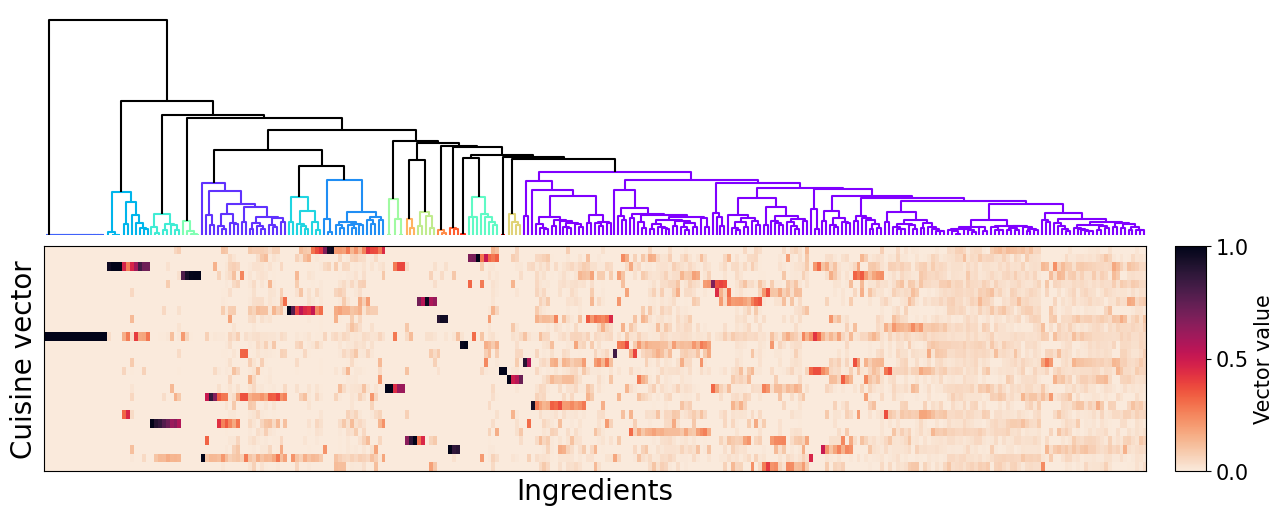

In [83]:
full = False
save_things = False

figsize = (25, 6) if full else (15, 6)
fig = plt.figure(figsize=figsize)

# Define gridspecs for layout
gs0 = GridSpec(1, 2, figure=fig, width_ratios=[35, 1], wspace=0.05)
gs1 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[0], height_ratios=[1, 1], hspace=0.05)
gs2 = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs0[1], height_ratios=[1, 1], hspace=0.05)

# Add subplots
legend_ax = fig.add_subplot(gs2[1])
ax_col_dendrogram = fig.add_subplot(gs1[0])

# Plot dendrogram
# col_dendrogram = dendrogram(
#     Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black',
#     link_color_func=lambda x: link_cols[x]
# )
col_dendrogram = dendrogram(
    Z, ax=ax_col_dendrogram, color_threshold=0, above_threshold_color='black',link_color_func=lambda x: link_cols[x] )

ax_col_dendrogram.set_axis_off()

# Get x-axis indices and limits
xind = col_dendrogram['leaves']
xmin, xmax = ax_col_dendrogram.get_xlim()

# Plot heatmap
ax = fig.add_subplot(gs1[1], sharex=ax_col_dendrogram)
colrow = ax.imshow(
    cs_i_vectors.loc[ingredient_list, cuisine_list].iloc[xind].to_numpy().T,
    cmap='rocket_r', aspect='auto', extent=[xmin, xmax, 0, 1], interpolation='nearest'
)
ax.set_yticks([])
ax.set_ylabel('Cuisine vector', rotation=90, size=20)
ax.set_xlabel('Ingredients', size=20)
ax.set_xticks([])

# Add colorbar
vcbar = fig.colorbar(colrow, cax=legend_ax, orientation='vertical')
legend_ax.set_yticks([0, 0.5, 1])
legend_ax.tick_params(axis='y', labelsize=15)
vcbar.set_label('Vector value', size=15)  # Set label text and size

# Add detailed labels if `full`
if full:
    ax.set_yticks(np.linspace(0, 1, len(cuisine_list) + 1)[:-1] + 1 / (2 * (len(cuisine_list) + 1)))
    ax.set_yticklabels(cuisine_list[::-1], ha='right', size=6)

    ax.set_xticks(np.linspace(xmin, xmax, len(ind_to_id[xind]) + 1)[:-1] + (xmax - xmin) / (2 * (len(ind_to_id[xind]) + 1)))
    ax.set_xticklabels(ind_to_id[xind], rotation=90, ha='center', size=5)
    xlbls = ax.get_xmajorticklabels()
    for lbl in xlbls:
        label = lbl.get_text()
        colour = leaf_palette.get(label, False)
        if colour:
            lbl.set_color(colour)
    cbar_ax = fig.add_subplot(gs2[0])
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=cluster_labels[::2])
    # cbar = fig.colorbar(sm, cax=cbar_ax, label='Cluster rank', ticks=cluster_labels)
    cbar.set_label('Cluster rank', size=15)
    cbar.ax.tick_params(labelsize=12)
    cbar_ax.tick_params(which='minor', bottom=False, top=False, left=False, right=False)


# Save the figure if required
if save_things:
    suffix = '_full' if full else ''
    plt.savefig(f'../../figures/rn/f3a_dendrogram{suffix}.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'../../figures/rn/f3a_dendrogram{suffix}.png', dpi=300, bbox_inches='tight')

plt.show()


In [84]:
metric = 'euclidean'
method = 'ward'
ind_to_id = np.array(cuisine_list)
Z = linkage(is_c_vectors.loc[ind_to_id, ingredient_list], metric=metric, method=method) ####### linkage


In [85]:
cutoff = 0.4
t = cutoff*max(Z[:,2])

exact_clustering_from_cols = dict()
small_clstr = set()
assigned=set()

# rawcolours = np.array(dendrograms['leaves_color_list'])
rawcolours = fcluster(Z=Z, t=t, criterion='distance') 


for i in list(set(rawcolours)): # remove the "other" unlcustered nodes
    if i != 'C000000':
        col_cl = set(np.array(ind_to_id)[np.where(rawcolours==i)])
        if len(col_cl) > 1: # don't take clusters of size 1
            exact_clustering_from_cols[i] = col_cl
            assigned |= col_cl
        else:
            small_clstr |= col_cl
exact_clustering_from_cols = {rank+1: v for rank, (_, v) in enumerate(sorted(exact_clustering_from_cols.items(), key=lambda item: len(item[1]), reverse=True))}
cluster_labels = list(exact_clustering_from_cols.keys())
cluster_lens = [len(exact_clustering_from_cols.get(i)) for i in cluster_labels]

cluster_lens_tuple = sorted(list(zip(cluster_labels, cluster_lens)), key=lambda x: -x[1])

plot_n = None

clusters_to_plot = [exact_clustering_from_cols.get(i[0]) for i in cluster_lens_tuple[:plot_n]]
cluster_labels_to_plot = [i[0] for i in cluster_lens_tuple[:plot_n]]
palette = cm.rainbow(np.linspace(0,1,len(cluster_labels_to_plot))) # sns.color_palette('husl', n_colors=plot_n).as_hex()
palette_dict = dict(zip(cluster_labels_to_plot, [to_hex(i) for i in palette]))

leaf_clabel_dict = {}
for key, val in exact_clustering_from_cols.items():
    for i in val:
        leaf_clabel_dict[i] = key


# animals_of_interest = np.hstack([list(i) for i in clusters_to_plot])

leaf_palette = {}
dflt_col = "black"   # Unclustered black

for i in ind_to_id:
    leaf_palette[i] = palette_dict.get(leaf_clabel_dict.get(i), dflt_col)

# Sorted cluster labels and their colors
cluster_labels = sorted(palette_dict.keys())
cluster_colors = [palette_dict[k] for k in cluster_labels]

# Create colormap and norm
cmap = mcolors.ListedColormap(cluster_colors)
bounds = np.array(cluster_labels + [max(cluster_labels) + 1]) - 0.5  # to center color ticks
norm = mcolors.BoundaryNorm(bounds, cmap.N)

link_cols = {}
for i, i12 in enumerate(Z[:,:2].astype(int)):
  c1, c2 = (link_cols[x] if x > len(Z) else leaf_palette[ind_to_id[x]]
    for x in i12)
  link_cols[i+1+len(Z)] = c1 if c1 == c2 else dflt_col


In [86]:
ddata = dendrogram(Z, no_plot=True)
# leaf_coords = dict(zip(ddata['ivl'], ddata['leaves']))
leaf_coords = dict(zip(ddata['leaves'], ddata['ivl']))

In [88]:
rawcolours

array([1, 5, 3, 3, 4, 6, 6, 1, 3, 4, 3, 5, 5, 3, 4, 3, 6, 2, 3, 4, 2, 5,
       3, 3, 2, 6], dtype=int32)

In [89]:
for i in list(set(rawcolours)): # remove the "other" unlcustered nodes
    # if i != 'C000000':
    col_cl = np.where(rawcolours==i)[0]
    if len(col_cl) > 1: # don't take clusters of size 1
        print(col_cl)
        #     assigned |= col_cl
        # else:
        #     small_clstr |= col_cl


[0 7]
[17 20 24]
[ 2  3  8 10 13 15 18 22 23]
[ 4  9 14 19]
[ 1 11 12 21]
[ 5  6 16 25]


In [90]:
col_cl = np.where(rawcolours==2)[0]

In [ ]:
leaf_labels = col_cl

# Get their indices
leaf_indices = [leaf_coords[label] for label in leaf_labels]

cluster_id, height = find_branch_point(Z, leaf_labels)

x =[ddata['leaves'][label] for label in leaf_labels]

reversed_link_cols = {}
for ind, val in enumerate(link_cols.items()):
    key, color = val
    # print(ind)
    # print(key)
    if color not in reversed_link_cols:
        reversed_link_cols[color] = []
    reversed_link_cols[color].append(ind)


In [96]:

# icoord and dcoord are the x and y values of the dendrogram linkages.
# Z encodes the order in which the clusters are formed, i.e. sorted by y values

# But the order in which icoord and dcoord are stored in the plotting is by 
# the order in which they are drawn, i.e. the x values. We must correct this to correspond.  

icdc = np.hstack([ddata['icoord'], ddata['dcoord']])
sorted_icdc = np.vstack(sorted(icdc, key=lambda x: x[5]))


In [ ]:

link_coords = []
for key, val in reversed_link_cols.items():
    if key != 'black':
        cluster_icdc = sorted_icdc[val]
        argy = np.argmax(cluster_icdc[:,5])
        y = cluster_icdc[:,5][argy]
        # x = ((cluster_icdc[argy][3]) + (cluster_icdc[argy][0]))/2
        x =  (cluster_icdc[argy][0])

        link_coords.append([x, y, key])

link_coords = sorted(link_coords, key=lambda x:x[0]) # sort back to plotting sequence

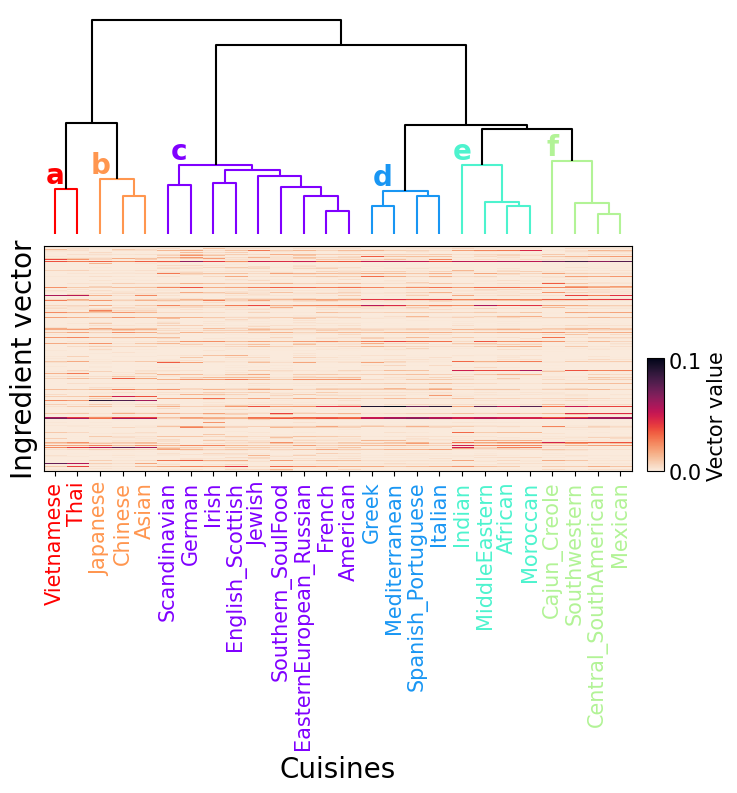

In [ ]:
save_things = False
fig = plt.figure(figsize=(8, 6))

gs0 = GridSpec(1,2, figure=fig,width_ratios=[35,1], wspace=0.05)
gs1 = GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[1,1],
                                                  hspace=0.05)

gs2 = GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[1],
                                                  height_ratios=[3,1],
                                                  hspace=0.05)

legend_ax = fig.add_subplot(gs2[1])


ax_col_dendrogram = fig.add_subplot(gs1[0])

col_dendrogram = dendrogram(Z, ax=ax_col_dendrogram, color_threshold=0 , above_threshold_color='black', link_color_func=lambda x: link_cols[x])
ax_col_dendrogram.set_axis_off()


labels = 'abcdef'

for plotitems, l in zip(link_coords, labels):
    x, y, c = plotitems
    ax_col_dendrogram.text(x, y, l, color=c, ha='center', va='bottom', size=20, bbox=dict(pad=2, fc='none', ec='None'), weight='bold')


xind = col_dendrogram['leaves']

xmin,xmax = ax_col_dendrogram.get_xlim()


# heatmap ax:
ax = fig.add_subplot(gs1[1], sharex=ax_col_dendrogram)
colrow = ax.imshow(is_c_vectors.loc[ind_to_id, ingredient_list].iloc[xind].to_numpy().T, cmap='rocket_r', aspect='auto', extent=[xmin,xmax,0,1], interpolation='nearest')

ax.set_yticks([])
ax.set_ylabel('Ingredient vector', rotation=90, size=20)
ax.set_xlabel('Cuisines', rotation=0, size=20)
ax.set_xticklabels(ind_to_id[xind], fontsize=15)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right', verticalalignment='center', rotation_mode='anchor')
legend_ax.tick_params(length=0)        

vcbar = fig.colorbar(colrow, cax=legend_ax, orientation='vertical')
vcbar.set_label(label='Vector value', fontsize=15)

legend_ax.tick_params(axis='y', labelsize=15)



# colour the leaves:
xlbls = ax.get_xmajorticklabels()
for lbl in xlbls:
    label = lbl.get_text()
    colour = leaf_palette.get(label, False)
    if colour:
        lbl.set_color(colour)
# save_things = False
if save_things:
    plt.savefig(f'../figures/rn/f3b_dendrogram.pdf', dpi=300, bbox_inches='tight')
    plt.savefig(f'../figures/rn/f3b_dendrogram.png', dpi=300, bbox_inches='tight')

plt.show()